# Unlocking Business Potential: Leveraging Bias-Aware Hierarchical Clustering for Actionable Insights from Yelp Data

### Zeinab Gaeini, Debbie Hernandez, Harper Strickland

## Part 1 - EDA

### Exploring Yelp Dataset - Business and Review Data

In [2]:
import pyspark
from pyspark.sql import SparkSession
import pandas as pd
import json
from PIL import Image
from pyspark.sql.functions import explode, from_json, col, regexp_replace, trim, lit
from pyspark.sql.functions import lower, split, size, expr, when, count, mean
import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType
import matplotlib.pyplot as plt 
import geopandas as gpd
from shapely.geometry import Point


In [3]:
# Suppress native-hadoop warning
!sed -i '$a\# Add the line for suppressing the NativeCodeLoader warning \nlog4j.logger.org.apache.hadoop.util.NativeCodeLoader=ERROR,console' /$HADOOP_HOME/etc/hadoop/log4j.properties

In [3]:
# make a directory on hdfs
! hdfs dfs -mkdir /Project/

mkdir: `/Project': File exists


In [5]:
# copy files to hdfs
! hdfs dfs -copyFromLocal yelp_academic_dataset_business.json /Project
! hdfs dfs -copyFromLocal yelp_academic_dataset_review.json /Project
! hdfs dfs -copyFromLocal USZIPCodes202403.csv /Project

copyFromLocal: `/Project/yelp_academic_dataset_business.json': File exists
copyFromLocal: `/Project/yelp_academic_dataset_review.json': File exists


In [4]:
! hdfs dfs -ls /Project

Found 2 items
-rw-r--r--   1 root supergroup  118863795 2024-06-03 13:46 /Project/yelp_academic_dataset_business.json
-rw-r--r--   1 root supergroup 5341868833 2024-06-03 13:46 /Project/yelp_academic_dataset_review.json


In [6]:
# Start Spark Session
conf = pyspark.SparkConf().setAll([
        ('spark.master',   'local[*]'),
        ('spark.app.name', 'EDA')])

spark = SparkSession.builder.config(conf=conf).getOrCreate()
spark.version

'3.5.0'

## Step 1: Exploring the dataset

#### 1.1. Reading and Storing data
In this step, we read each table and save them as individual dataframes.

### 1.1.1. Business DataFrame

**Businesses on Yelp with associated details**

**Importing data**

In [7]:
businessDF = spark.read.json('hdfs:///Project/yelp_academic_dataset_business.json')

In [8]:
businessDF.show(2, truncate=False, vertical=True)

-RECORD 0--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 address      | 1616 Chapala St, Ste 2                                                                                                                                                                                                                     
 attributes   | {NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, True, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL} 
 business_id  | Pns2l4eNsfO8kk83dixA6A                                                                                                                                                                                                              

### Looking into business data

In [9]:
# Define a function for counting the rows and printing schema for each dataset

def basicEDA(df):
    print("Rows:", df.count())
    print("\nSchema:")
    df.printSchema()  # schema
    print("Null Values:")
    
    #count number of null values in each column of DataFrame
    df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show(2, vertical= True, truncate=False)
    return

In [10]:
basicEDA(businessDF)

Rows: 150346

Schema:
root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |

-RECORD 0-------------
 address      | 0     
 attributes   | 13744 
 business_id  | 0     
 categories   | 103   
 city         | 0     
 hours        | 23223 
 is_open      | 0     
 latitude     | 0     
 longitude    | 0     
 name         | 0     
 postal_code  | 0     
 review_count | 0     
 stars        | 0     
 state        | 0     



**Now we have this information about the business dataset:**

Business file contains rows of businesses

- Schema:
    - business_id
    - name
    - address
    - city
    - state
    - postal_code
    - lattitude
    - longitude
    - stars
    - review_count
    - is_open (0 or 1)
    - attributes (array of text:true options)
    - categories (text comma separated)
    - hours


- We have about **150 thousand** rows of data
- There are some null values for businesses, including attributes (9%), categories (0.06%), hours (15%) 
- Business location: address, city, state, postal_code, latitude, longitude
- Other variables:
    - Stars (rating from 1 to 5)
    - Review count: number of reviews for each business
    - Attributes: A collection of business-specific features or characteristics such as whether a business offers Wi-Fi, accepts credit cards, has outdoor seating, etc.
    - Categories: The categorization of the business into one or more predefined groups or types such as "Restaurants," "Coffee Shops," "Hair Salons," etc.
    - Hours: Information about the operating hours of the business


### 1.1.2. Review DataFrame

**User-generated reviews of businesses on Yelp**

**Importing data**

In [8]:
reviewDF = spark.read.json('hdfs:///Project/yelp_academic_dataset_review.json')

In [12]:
reviewDF.show(2, vertical= True, truncate=False)

-RECORD 0------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 business_id | XQfwVwDr-v0ZS3_CbbE5Xw                                                                                                                 

### Looking into review data

In [13]:
basicEDA(reviewDF)

Rows: 6990280

Schema:
root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

Null Values:


-RECORD 0----------
 business_id | 0   
 cool        | 0   
 date        | 0   
 funny       | 0   
 review_id   | 0   
 stars       | 0   
 text        | 0   
 useful      | 0   
 user_id     | 0   



**Now we have this information about the review dataset:**

Review file contains rows of reviews

- Schema:
    - review_id
    - user_id
    - business_id
    - stars (1-5 integer)
    - useful
    - funny
    - cool
    - text
    - date (as string)


- We have about **7 million** rows of data
- Zero null values
- String: user ID, business ID, text, date
- Numeric: user ratings (stars), rating attributes (useful, funny, cool)
- Text: review text
- Date: Date and time the review was posted


## Step 2: Exploratory Data Analysis (EDA) 

### 2.1. Business dataset

#### 2.1.1. Open or Closed?

In [14]:
# is_open variable is 0 (closed businesses) or 1 (open businesses) 

print((businessDF.filter(col('is_open') == 1).count() / businessDF.count()) * 100 , 'percent of businesses are listed as open')


79.61502135075094 percent of businesses are listed as open


So, about 20% of businesses listed as closed.

#### 2.1.2. Geographical insights

Within this dataset, several variables related to the geographical location of each business, encompassing details such as address, state, city, latitude, and longitude. Let's delve into a closer examination of some of these location-based attributes.

**States**

In [15]:
# number of states
print('The number of unique states:', businessDF.select(businessDF.state).distinct().count())

The number of unique states: 27


In [16]:
# List of states with the most number of businesses
businessDF.groupby('state').count().orderBy('count', ascending = False).show(10)

+-----+-----+
|state|count|
+-----+-----+
|   PA|34039|
|   FL|26330|
|   TN|12056|
|   IN|11247|
|   MO|10913|
|   LA| 9924|
|   AZ| 9912|
|   NJ| 8536|
|   NV| 7715|
|   AB| 5573|
+-----+-----+
only showing top 10 rows



**Cities**

In [17]:
# number of cities
print('The number of unique cities:', businessDF.select(businessDF.city).distinct().count())

The number of unique cities: 1416


In [18]:
# List of cities with the most number of businesses
businessDF.groupby('city').count().orderBy('count', ascending = False).show(10)

+-------------+-----+
|         city|count|
+-------------+-----+
| Philadelphia|14569|
|       Tucson| 9250|
|        Tampa| 9050|
| Indianapolis| 7540|
|    Nashville| 6971|
|  New Orleans| 6209|
|         Reno| 5935|
|     Edmonton| 5054|
|  Saint Louis| 4827|
|Santa Barbara| 3829|
+-------------+-----+
only showing top 10 rows



**Plots**

1. Bar chart: distribution of businesses across different states


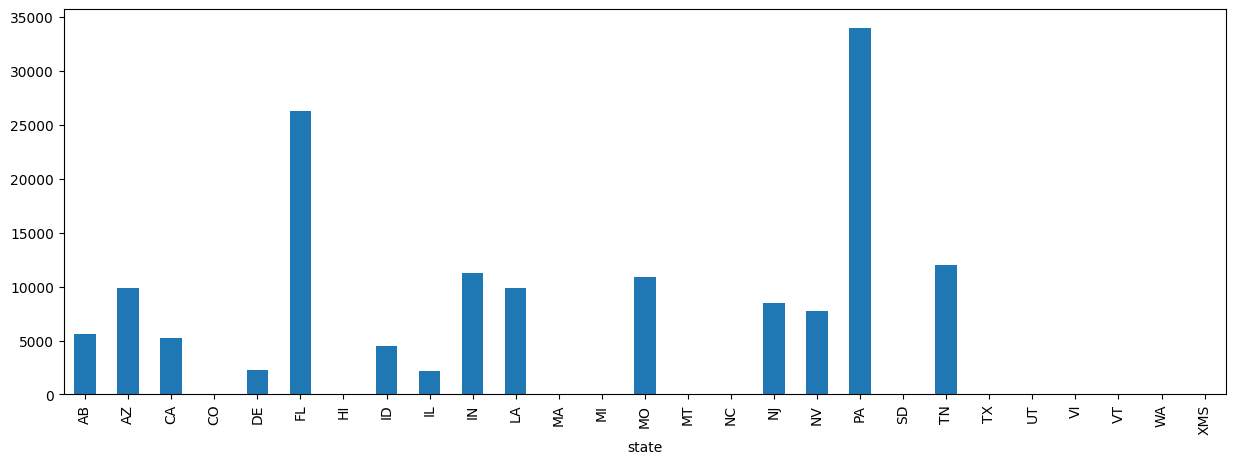

In [19]:
# Plot a bar chart to indicating the number of businesses in each state

# Save data frame as Pandas df
business = businessDF.toPandas()

plt.figure(figsize=(15,5))
business.state.value_counts().sort_index().plot.bar()
plt.show()

2. A geographical perspective: map of the United States with marked business locations


In [20]:
# function to display US map and business coordinates
def show_map(business, long_col, lat_col):
    # Create GeoDataFrame from latitude and longitude
    geometry = [Point(lon, lat) for lon, lat in zip(business[long_col], business[lat_col])]
    gdf = gpd.GeoDataFrame(business, geometry=geometry, crs='EPSG:4326')
    
    # Load the US shapefile 
    us_map = gpd.read_file('cb_2018_us_state_500k/cb_2018_us_state_500k.shp')
    
    # Trim data and drop low and high longitudes for a clearer result 
    us_map['min_longitude'] = us_map.geometry.get_coordinates().reset_index().groupby('index').x.min()
    us_map.sort_values('min_longitude').NAME.head()
    us_map.sort_values('min_longitude').NAME.tail()
    
    # Plot the US map
    fig, ax = plt.subplots(figsize=(10, 8))
    us_map.loc[~us_map.NAME.isin(
        ['Alaska', 'Hawaii', 'American Samoa', 'Puerto Rico',
         'United States Virgin Islands', 'Guam',
         'Commonwealth of the Northern Mariana Islands']
    )].plot(ax=ax, color='grey')
    for idx, row in us_map.iterrows():
        plt.annotate(
           text=row.STUSPS,
           xy=row.geometry.representative_point().coords[:][0],
           ha='center',
           color='black')
    # Plot the points on the map
    gdf.plot(ax=ax, color='red', marker='o', markersize=50)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Points on US Map')
    plt.show()

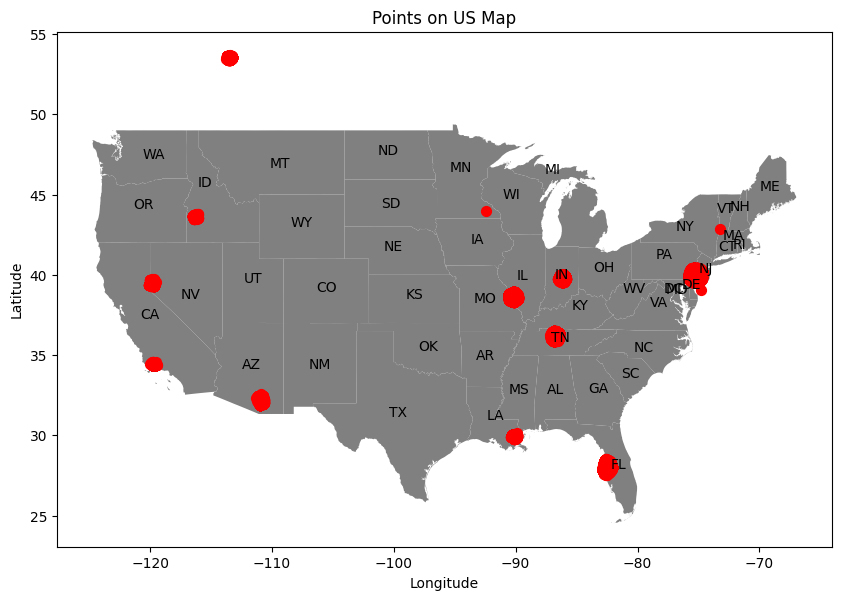

In [21]:
show_map(business, 'longitude', 'latitude')

This plot demonstrates that the latitude and longitude provided by Yelp are at the state level rather than precise coordinates of business locations. To rectify this, we utilized a secondary data source file containing precise latitude and longitude coordinates based on zip codes. We then plotted the map again with accurate coordinates.

In [22]:
# Save the zipcode file as a spark df
zip_codes = spark.read.csv('hdfs:///Project/USZIPCodes202403.csv', header = True)

In [23]:
# Merge the new zipcode file with business data
business_zip = businessDF.join(zip_codes, businessDF['postal_code'] == zip_codes['Zip Code'])

In [24]:
business_new_zip = business_zip.toPandas()

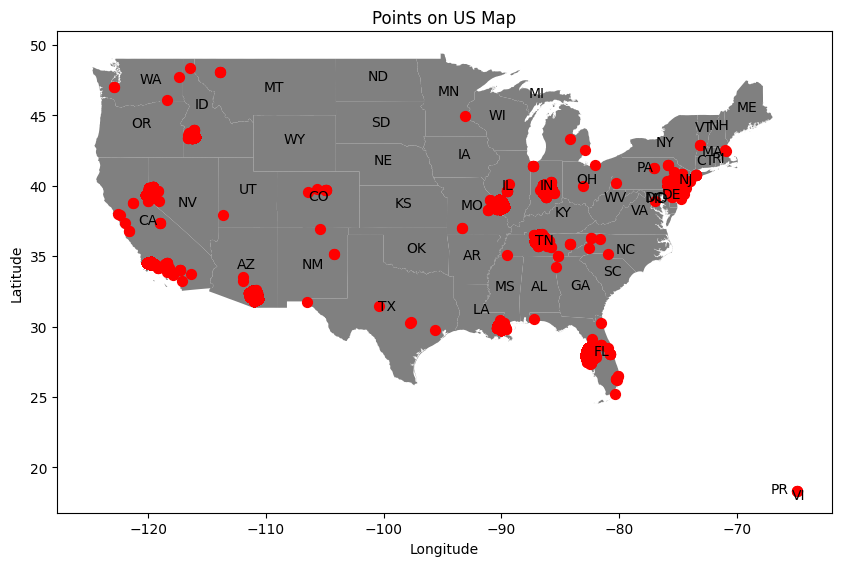

In [25]:
show_map(business_new_zip, 'ZipLongitude', 'ZipLatitude')

This map now illustrates the actual business locations from the Yelp dataset.

#### 2.1.3. Attributes

The "attributes" variable contains a detailed set of characteristics or features associated with each business. These attributes can include specific amenities, service options, and other qualitative aspects of the business, typically presented as a dictionary or key-value pairs.

When the data is read from a JSON file, these attributes are stored as a struct variable in the Spark DataFrame. To make the attributes more accessible and readable, we flatten the struct to extract the individual attribute names and their corresponding values.

In [10]:
attribute_names = [field.name for field in businessDF.schema['attributes'].dataType]
attribute_names

['AcceptsInsurance',
 'AgesAllowed',
 'Alcohol',
 'Ambience',
 'BYOB',
 'BYOBCorkage',
 'BestNights',
 'BikeParking',
 'BusinessAcceptsBitcoin',
 'BusinessAcceptsCreditCards',
 'BusinessParking',
 'ByAppointmentOnly',
 'Caters',
 'CoatCheck',
 'Corkage',
 'DietaryRestrictions',
 'DogsAllowed',
 'DriveThru',
 'GoodForDancing',
 'GoodForKids',
 'GoodForMeal',
 'HairSpecializesIn',
 'HappyHour',
 'HasTV',
 'Music',
 'NoiseLevel',
 'Open24Hours',
 'OutdoorSeating',
 'RestaurantsAttire',
 'RestaurantsCounterService',
 'RestaurantsDelivery',
 'RestaurantsGoodForGroups',
 'RestaurantsPriceRange2',
 'RestaurantsReservations',
 'RestaurantsTableService',
 'RestaurantsTakeOut',
 'Smoking',
 'WheelchairAccessible',
 'WiFi']

In [11]:
# Dataframe with all the attributes as columns
all_businessDF = businessDF.select(businessDF.columns + [col('attributes')[field].alias(field) for field in attribute_names]).drop('attributes')
all_businessDF.cache()

DataFrame[address: string, business_id: string, categories: string, city: string, hours: struct<Friday:string,Monday:string,Saturday:string,Sunday:string,Thursday:string,Tuesday:string,Wednesday:string>, is_open: bigint, latitude: double, longitude: double, name: string, postal_code: string, review_count: bigint, stars: double, state: string, AcceptsInsurance: string, AgesAllowed: string, Alcohol: string, Ambience: string, BYOB: string, BYOBCorkage: string, BestNights: string, BikeParking: string, BusinessAcceptsBitcoin: string, BusinessAcceptsCreditCards: string, BusinessParking: string, ByAppointmentOnly: string, Caters: string, CoatCheck: string, Corkage: string, DietaryRestrictions: string, DogsAllowed: string, DriveThru: string, GoodForDancing: string, GoodForKids: string, GoodForMeal: string, HairSpecializesIn: string, HappyHour: string, HasTV: string, Music: string, NoiseLevel: string, Open24Hours: string, OutdoorSeating: string, RestaurantsAttire: string, RestaurantsCounterServ

In [28]:
# Count the number of nulls in each value
null_counts = [all_businessDF.select(F.sum(col(i).isNull().cast('int'))).collect() for i in attribute_names]

In [29]:
# Count the number of not null (True) values in each column
not_null_att = []
for i in range(len(attribute_names)):
    not_null_att.append(all_businessDF.count() - null_counts[i][0][0])

In [30]:
data = zip(attribute_names, not_null_att)
att_count = spark.createDataFrame(data, ["attribute_names", "count"])

In [31]:
att_count.orderBy('count', ascending = False).show()

+--------------------+------+
|     attribute_names| count|
+--------------------+------+
|BusinessAcceptsCr...|119765|
|     BusinessParking| 91085|
|RestaurantsPriceR...| 85314|
|         BikeParking| 72638|
|  RestaurantsTakeOut| 59857|
|                WiFi| 56914|
| RestaurantsDelivery| 56282|
|         GoodForKids| 53375|
|      OutdoorSeating| 48802|
|RestaurantsReserv...| 45247|
|               HasTV| 45084|
|            Ambience| 44279|
|RestaurantsGoodFo...| 44170|
|             Alcohol| 43189|
|   ByAppointmentOnly| 42339|
|              Caters| 40127|
|   RestaurantsAttire| 39255|
|          NoiseLevel| 37993|
|         GoodForMeal| 29087|
|WheelchairAccessible| 28953|
+--------------------+------+
only showing top 20 rows



In [13]:
# Create a new df to see all the attributes as columns
attributesDF = businessDF.select(businessDF.business_id, businessDF.attributes).cache()
for i in range (39):
    attributesDF = attributesDF.withColumn(businessDF.schema['attributes'].dataType.names[i], 
                col('attributes.{}'.format(businessDF.schema['attributes'].dataType.names[i])))
attributesDF = attributesDF.drop('attributes')

In [14]:
# Count the number of null values in attributes df
total_rows = attributesDF.count()
null_percentage_df = attributesDF.select([(count(when(col(c).isNull() , c)) / total_rows).alias(c) for c in attributesDF.columns])

# Show the result
null_percentage_df.show(vertical=True)

-RECORD 0-----------------------------------------
 business_id                | 0.0                 
 AcceptsInsurance           | 0.9620009843959932  
 AgesAllowed                | 0.9991419791680524  
 Alcohol                    | 0.7127359557287856  
 Ambience                   | 0.7054860122650419  
 BYOB                       | 0.970394955635667   
 BYOBCorkage                | 0.9903954877416093  
 BestNights                 | 0.9621273595572879  
 BikeParking                | 0.516861107046413   
 BusinessAcceptsBitcoin     | 0.8840674178228886  
 BusinessAcceptsCreditCards | 0.20340414776582016 
 BusinessParking            | 0.3941641280779003  
 ByAppointmentOnly          | 0.7183895813656499  
 Caters                     | 0.7331023106700544  
 CoatCheck                  | 0.9628590052279409  
 Corkage                    | 0.9763678448379072  
 DietaryRestrictions        | 0.9997938089473615  
 DogsAllowed                | 0.8783871868889096  
 DriveThru                  | 0

columns with insignificant usage in any category:
- AgesAllowed: 0.03% of all open businesses labeled over18 or over21
- Open24Hours: 0.01% of all open businesses labeled true
- RestaurantsCounterService: 0.01% of all open businesses labeled true
- DietaryRestrictions: 0.01% of all open businesses used any available labels

#### 2.1.4. Categories

In the Yelp dataset, the "categories" variable typically refers to the type or genre of a business. It includes a range of business classifications, such as "restaurants," "shopping," "nightlife," and more.

In [15]:
businessDF.select(businessDF['categories']).show(5, vertical= True,truncate=False)

-RECORD 0----------------------------------------------------------------------------------------------------------------
 categories | Doctors, Traditional Chinese Medicine, Naturopathic/Holistic, Acupuncture, Health & Medical, Nutritionists 
-RECORD 1----------------------------------------------------------------------------------------------------------------
 categories | Shipping Centers, Local Services, Notaries, Mailbox Centers, Printing Services                             
-RECORD 2----------------------------------------------------------------------------------------------------------------
 categories | Department Stores, Shopping, Fashion, Home & Garden, Electronics, Furniture Stores                         
-RECORD 3----------------------------------------------------------------------------------------------------------------
 categories | Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries                                                      
-RECORD 4---------------

In [16]:
# Count the number of each category
categories = businessDF.select(split(businessDF["categories"], ', ').alias('cat')).select(explode('cat').alias('Category'))
cat_num = categories.groupBy('Category').count()
cat_num.orderBy('count', ascending = False).show(truncate=False)

+-------------------------+-----+
|Category                 |count|
+-------------------------+-----+
|Restaurants              |52268|
|Food                     |27781|
|Shopping                 |24395|
|Home Services            |14356|
|Beauty & Spas            |14292|
|Nightlife                |12281|
|Health & Medical         |11890|
|Local Services           |11198|
|Bars                     |11065|
|Automotive               |10773|
|Event Planning & Services|9895 |
|Sandwiches               |8366 |
|American (Traditional)   |8139 |
|Active Life              |7687 |
|Pizza                    |7093 |
|Coffee & Tea             |6703 |
|Fast Food                |6472 |
|Breakfast & Brunch       |6239 |
|American (New)           |6097 |
|Hotels & Travel          |5857 |
+-------------------------+-----+
only showing top 20 rows



In [17]:
# Count the number of unique categories
categories = cat_num.select('Category')
categories.count()

1311

#### Feature Density by Category

Based on Professor Nguyen's feedback during Project Proposal, we explored which categories have least nulls in attributes columns.
Categories with fewer nulls in attributes columns per business = higher density of features.
These categories are better candidates for analysis.

In [18]:
# get DF with business_id and count of null attributes
att_nulls = attributesDF.select('business_id', lit(sum(attributesDF[col].isNull().cast('int') for col in attributesDF.columns)).alias('nulls'))

In [19]:
# join attribute nulls with businesses (1 row per category - exploded)
tempdf = businessDF.select('business_id', explode(split(businessDF.categories, ', ')).alias('category'))
densityDF = att_nulls.join(tempdf, att_nulls.business_id == tempdf.business_id, 'inner').drop(tempdf.business_id)


In [20]:
# get category, business count, average nulls (each business nulls are total for attribute columns)
cat_density = densityDF.groupBy("category").agg(count('business_id').alias('bus_count'), mean("nulls").alias("avg_nulls")) \
                        .orderBy('avg_nulls', ascending = True)
# only include categories with >300 businesses
cat_density = cat_density.where(cat_density.bus_count > 300) 

In [21]:
cat_density.show(truncate=False)

+----------------------+---------+------------------+
|category              |bus_count|avg_nulls         |
+----------------------+---------+------------------+
|Gastropubs            |513      |17.341130604288498|
|Cocktail Bars         |1718     |18.28230500582072 |
|Tapas/Small Plates    |440      |18.895454545454545|
|Wine Bars             |1192     |18.923657718120804|
|Beer Bar              |870      |18.99655172413793 |
|Sports Bars           |2110     |19.113270142180095|
|Steakhouses           |1506     |19.52722443559097 |
|American (New)        |6097     |19.82909627685747 |
|Pubs                  |1821     |20.040637012630423|
|American (Traditional)|8139     |20.20186755129623 |
|Bars                  |11065    |20.238047898779936|
|Comfort Food          |746      |20.447721179624665|
|Gluten-Free           |777      |20.454311454311455|
|Vegetarian            |1158     |20.46027633851468 |
|Southern              |988      |20.661943319838056|
|Nightlife             |1228

#### 2.1.5. Stars (ratings)

Rating in the Yelp dataset is based on stars (from 1 to 5)

In [22]:
businessDF.select('stars').describe().show()
businessDF.agg({"stars": "mode"}).show()

+-------+------------------+
|summary|             stars|
+-------+------------------+
|  count|            150346|
|   mean|3.5967235576603303|
| stddev|0.9744207509201349|
|    min|               1.0|
|    max|               5.0|
+-------+------------------+

+-----------+
|mode(stars)|
+-----------+
|        4.0|
+-----------+



In [23]:
business = businessDF.toPandas()

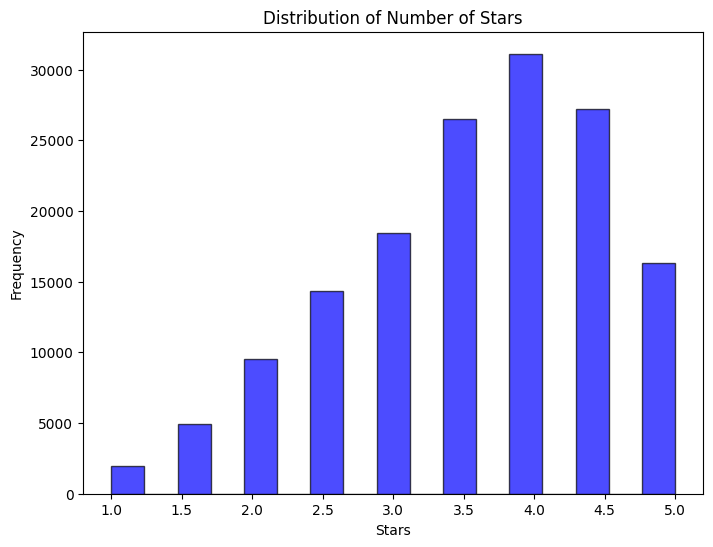

In [24]:
# Plot the distribution of stars
plt.figure(figsize=(8, 6))
business['stars'].hist(bins=17, color='blue', edgecolor='black', alpha=0.7)

# Add labels and title 
plt.title('Distribution of Number of Stars')
plt.xlabel('Stars')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

#### 2.1.6. Review Count

In [25]:
businessDF.select('review_count').describe().show()
businessDF.agg({"review_count": "mode"}).show()

+-------+------------------+
|summary|      review_count|
+-------+------------------+
|  count|            150346|
|   mean| 44.86656113232144|
| stddev|121.12013570117087|
|    min|                 5|
|    max|              7568|
+-------+------------------+

+------------------+
|mode(review_count)|
+------------------+
|                 5|
+------------------+



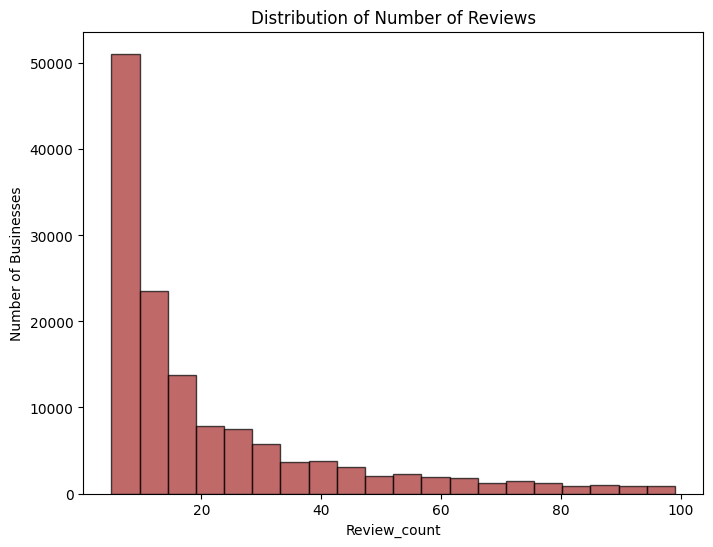

In [26]:
# Plot the distribution of number of reviews for each business
plt.figure(figsize=(8, 6))
business.loc[business.review_count < 100].review_count.hist(bins=20, color='brown', edgecolor='black', alpha=0.7)

# Add labels and title 
plt.title('Distribution of Number of Reviews')
plt.xlabel('Review_count')
plt.ylabel('Number of Businesses')
plt.grid(False)
plt.show()

### 2.2. Review Dataset

#### 2.2.1 Stars by users

Review Ratings: The number of stars assigned to individual reviews by users.

In [27]:
# get stars - number of reviews with each rating
star_count = reviewDF.groupBy('stars').count().orderBy('stars', ascending=True)
star_count.show()

+-----+-------+
|stars|  count|
+-----+-------+
|  1.0|1069561|
|  2.0| 544240|
|  3.0| 691934|
|  4.0|1452918|
|  5.0|3231627|
+-----+-------+



In [28]:
# stars to pandas
stars_pd = star_count.toPandas()


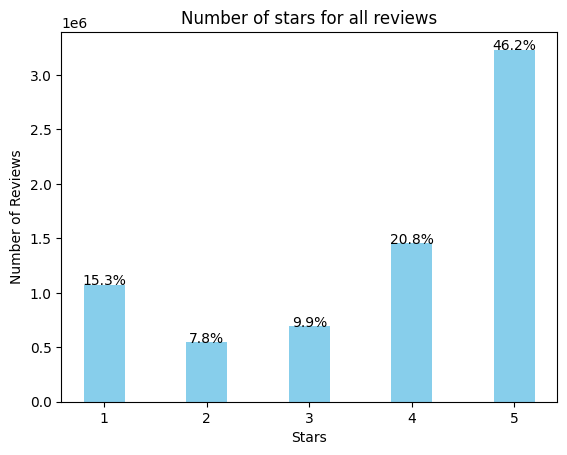

In [29]:
# Bar chart for ratings (number of stars) for reviews   
plt.bar(stars_pd['stars'], stars_pd['count'], color ='skyblue', 
        width = 0.4)

# Add percentage labels on top of the bars
values = stars_pd['count']
total = stars_pd['count'].sum()
percentages = [(value / total) * 100 for value in values]
for i, value in enumerate(values):
    plt.text(i+1, value, f'{percentages[i]:.1f}%', ha='center')

# Add labels and title  
plt.xlabel('Stars')
plt.ylabel('Number of Reviews')
plt.title('Number of stars for all reviews')
plt.show()

This plot reveals that a significant portion of the reviews (46.2%) received the highest rating of 5 stars.

#### 2.2.2. Word Count

We evaluated the review text in 2 different ways. First, we calculated the frequency of all words in the data set (all reviews combined). Second, we counted the length in words of each review.


**Counting words of all the rows of dataset**

In [30]:
# define a function for removing punctuations, splitting words, removing nulls and meaningless words, and counting the unique words 
def word_count(df , column, unwanted):
    removePunctuation = df.select(trim(lower(regexp_replace(column, "[^A-Za-z0-9 -]", ""))).alias("sentence"))
    removePunctuation = removePunctuation.select(split(removePunctuation["sentence"], ' ').alias('csv')).select(explode('csv').alias('word'))
    removePunctuation = removePunctuation.filter((removePunctuation.word.isNotNull()) & ~(col('word').isin(unwanted)))
    removePunctuation = removePunctuation.groupBy("word").count().orderBy("count", ascending=False)
    return removePunctuation

Note: this cell takes significant time to run:

In [31]:
unwanted = ['']

total_words = word_count(reviewDF, reviewDF.text, unwanted)
total_wc = total_words.count()
total_words.show(truncate = False)

# number of unique categories
print('This dataset has', total_wc, 'unique words')

+----+--------+
|word|count   |
+----+--------+
|the |36212583|
|and |26094976|
|a   |18765040|
|i   |18520917|
|to  |17695997|
|was |13436237|
|of  |10399233|
|it  |8776914 |
|is  |8654677 |
|for |8629999 |
|in  |8192581 |
|my  |6927232 |
|we  |6153178 |
|with|6065419 |
|that|6002934 |
|they|5837924 |
|this|5757091 |
|but |5414492 |
|on  |5101929 |
|you |4898044 |
+----+--------+
only showing top 20 rows

This dataset has 2859509 unique words


**Counting words for each review text**

In [32]:
df_with_word_count = reviewDF.withColumn("word_count", size(split(reviewDF['text'], " ")))

# Show the DataFrame with the word count
df_with_word_count = df_with_word_count.dropna().select('text', 'word_count')
df_with_word_count.orderBy("word_count", ascending=False).show()

+--------------------+----------+
|                text|word_count|
+--------------------+----------+
|I was in town vis...|      3079|
|Beginning of the ...|      1904|
|( The following r...|      1887|
|My wife and I rec...|      1566|
|Be very cautious ...|      1547|
|Yelper Conan M. r...|      1539|
|New Orleans Birth...|      1310|
|Reason: The stron...|      1300|
|Sorry to write th...|      1295|
|_________________...|      1247|
|Sweet Taste of Li...|      1234|
|4.5 Stars\n\nForm...|      1199|
|First meal back i...|      1135|
|Well,  I never sh...|      1134|
|MISSOURI SUCKS! T...|      1128|
|I have been takin...|      1098|
|My experience wit...|      1096|
|Ugh, where do you...|      1085|
|I LOVE  this best...|      1083|
|Jan. 18, 2014 - I...|      1080|
+--------------------+----------+
only showing top 20 rows



In [34]:
df_with_word_count.select('word_count').describe().show()
df_with_word_count.agg({"word_count": "mode"}).show()

+-------+------------------+
|summary|        word_count|
+-------+------------------+
|  count|           6990280|
|   mean|105.79662159455701|
| stddev| 98.75492880047332|
|    min|                 1|
|    max|              3079|
+-------+------------------+



+----------------+
|mode(word_count)|
+----------------+
|              26|
+----------------+



In [35]:
# examples of review text listed as zero word count
df_with_word_count.orderBy("word_count", ascending=True).show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|text                                                                                  

181 reviews contain only non-latin characters and/or punctuation and they are shown in word count with no words or one word. 

In [ ]:
spark.stop()